# Base Case: Circular Orbit of Radius 1 AU, Period 1 Year

Create synthetic data for the simplest base case: a circular orbit of radius 1.

Can think of this as approximating the earth: radius = 1 AU, period = 1 year, mass of sun $m_0$ = 1 solar mass

\begin{align}
x(t) &= \cos(\omega t) \\
y(t) &= \sin(\omega t) \\
\omega &= 2 \pi
\end{align}

Taking two derivatives
\begin{align}
\ddot{x}(t) = -\omega^2 x(t)\\
\ddot{y}(t) = -\omega^2 y(t)
\end{align}

Equating the acceleration $\omega^2 r$ to $G \cdot m_0 / r^2$ for $r=1$ in the case of earth, we can see that in these units the gravitational constant $G$ is
$$G = 4 \pi^2$$

Further we can see that for a planet in a circular orbit with radius $r$, the angular frequency will satisfy
$$ \omega^2 = G m_0 / r^3$$
This is a special case of Kepler's third law.

In [1]:
# Library imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

# Aliases
keras = tf.keras

In [195]:
# Local imports
from utils import load_vartbl, save_vartbl, plot_style
from tf_utils import gpu_grow_memory, TimeHistory
from tf_utils import Identity
from tf_utils import EpochLoss, TimeHistory

from r2b_data import make_traj_r2bc , make_train_r2bc
from r2b_data import plot_orbit_q, plot_orbit_v, plot_orbit_a, plot_orbit_energy
from r2b_data import make_datasets_earth, make_datasets_solar, make_datasets_r2bc

from r2b import KineticEnergy_R2B, PotentialEnergy_R2B
from r2b import AngularMomentum0_R2B, AngularMomentum_R2B
from r2b import ConfigToPolar2D
from r2b import Motion_R2B

from r2bc_model_math import make_position_model_r2bc_math, make_model_r2bc_math
from r2bc_model_nn import make_position_model_r2bc_nn, make_physics_model_r2bc_nn
from r2bc_model_nn import make_model_r2bc_nn

In [3]:
# Grow GPU memory (must be first operation in TF)
gpu_grow_memory()

In [4]:
# Create distribution strategy
# This isn't working properly for training in Michael-PC (Windows 10)
# but does work for evaluating (with no real benefit though)
# strat = tf.distribute.MirroredStrategy(['/GPU:0', '/GPU:1'])

# Plot style 
plot_style()

In [5]:
# Lightweight serialization
fname = '../pickle/r2bc.pickle'
vartbl = load_vartbl(fname)

In [6]:
# One trajectory of earth for plotting
inputs_earth, outputs_earth = make_traj_r2bc(r0=1.0, theta0=0.0, n_years=2)

# Combined dict
data_earth = {**inputs_earth, **outputs_earth}

In [7]:
# fig, ax = plot_orbit_q(data_earth)

In [8]:
# fig, ax = plot_orbit_v(data_earth)

In [9]:
# fig, ax = plot_orbit_a(data_earth)

In [10]:
# fig, ax = plot_orbit_energy(data_earth)

### Generate data sets and an example batch

In [11]:
# Create DataSet objects for toy size problem - earth orbits only (a=1, e=0)
ds_earth_trn, ds_earth_val, ds_earth_tst = make_datasets_earth(n_traj=1000, vt_split=0.20)

# Create DataSet objects for solar system type orbits (a between 0.25 and 32.0)
ds_solar_trn, ds_solar_val, ds_solar_tst = make_datasets_solar(n_traj=10000, vt_split=0.20)

# Create DataSet objects for jupiter orbits only (a=5.2, e=0)
ds_jup_trn, ds_jup_val, ds_jup_tst = make_datasets_r2bc(n_traj=1000, vt_split=0.20, 
                                                        n_years=2, r_min=5.2, r_max=5.2, seed=42, batch_size=64)

In [12]:
# Example batch
batch_in, batch_out = list(ds_earth_val.take(1))[0]
# batch_in.keys()
# batch_out.keys()

t = batch_in['t']
q0 = batch_in['q0']
v0 = batch_in['v0']
mu = batch_in['mu']

q = batch_out['q']
v = batch_out['v']
a = batch_out['a']
q0_rec = batch_out['q0_rec']
v0_rec = batch_out['v0_rec']
H = batch_out['H']
L = batch_out['L']

print(f'Example batch sizes:')
print(f't  = {t.shape}')
print(f'q0 = {q0.shape}')
print(f'v0 = {v0.shape}')
print(f'mu = {mu.shape}')

print(f'q  = {q.shape}')
print(f'v  = {v.shape}')
print(f'a  = {a.shape}')
# print(f'q0_rec = {q0_rec.shape}')
# print(f'v0_rec = {v0_rec.shape}')
print(f'H  = {H.shape}')
print(f'L  = {L.shape}')

Example batch sizes:
t  = (64, 731)
q0 = (64, 2)
v0 = (64, 2)
mu = (64, 1)
q  = (64, 731, 2)
v  = (64, 731, 2)
a  = (64, 731, 2)
H  = (64, 731)
L  = (64, 731)


In [13]:
batch_size = 64
traj_size = 731

tf.debugging.assert_shapes(
    shapes = {
    # Inputs
    t: (batch_size, traj_size),
    q0: (batch_size, 2),
    v0: (batch_size, 2),
    mu: (batch_size, 1),
    # Outputs
    q: (batch_size, traj_size, 2),
    v: (batch_size, traj_size, 2),
    a: (batch_size, traj_size, 2),
    q0_rec: (batch_size, 2),
    v0_rec: (batch_size, 2),
    H: (batch_size, traj_size),
    L: (batch_size, traj_size),
    })

**Call layers with physics computations**

In [14]:
T = KineticEnergy_R2B()(v)
T.shape

TensorShape([64, 731])

In [15]:
U = PotentialEnergy_R2B()([q, mu])
U.shape

TensorShape([64, 731])

In [16]:
L = AngularMomentum_R2B()([q, v])
L.shape

TensorShape([64, 731])

In [17]:
L0 = AngularMomentum0_R2B()([q0, v0])
L0.shape

TensorShape([64, 1])

**Conversion of initial configuration to polar coordinates**

In [18]:
r0, theta0, omega0 = ConfigToPolar2D()([q0, v0])
print(f'shape of polar batches')
print(f'r0 : {r0.shape}')
print(f'theta0 : {theta0.shape}')
print(f'omega0 : {omega0.shape}')

shape of polar batches
r0 : (64, 1)
theta0 : (64, 1)
omega0 : (64, 1)


### Mathematical Model
**Compute position as a function of time from initial polar coordinates**

In [19]:
position_model = make_position_model_r2bc_math(traj_size)

In [20]:
# Need to call the position model on RESHAPED t vector
# t_vec = tf.reshape(t, (batch_size, traj_size, 1))
# print(f'shape of t_vec = {t_vec.shape}')

In [21]:
qx, qy = position_model([t, r0, theta0, omega0])
print(f'qx = {qx.shape}')
print(f'qy = {qy.shape}')

qx = (64, 731, 1)
qy = (64, 731, 1)


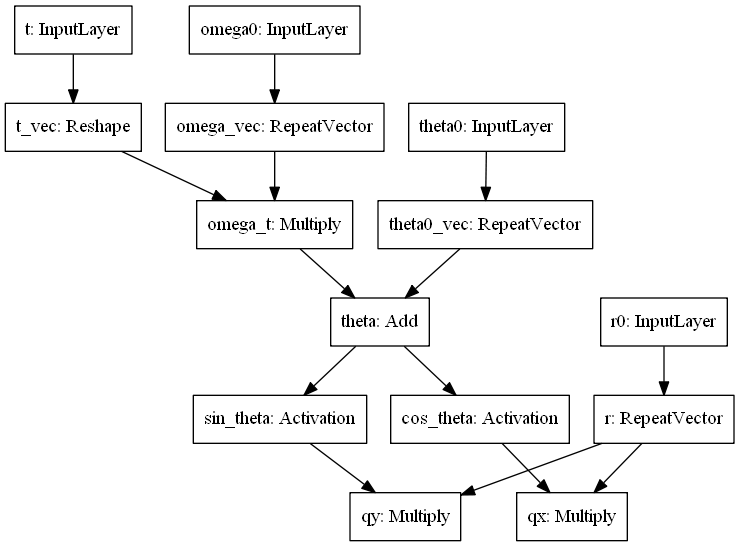

In [22]:
keras.utils.plot_model(position_model)

In [23]:
position_model.summary()

Model: "model_r2bc_math"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
omega0 (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
t (InputLayer)                  [(None, 731)]        0                                            
__________________________________________________________________________________________________
omega_vec (RepeatVector)        (None, 731, 1)       0           omega0[0][0]                     
__________________________________________________________________________________________________
t_vec (Reshape)                 (None, 731, 1)       0           t[0][0]                          
____________________________________________________________________________________

**Motion Model: Compute v and a from q using automatic differentiation**<br>
Factory function that accepts any position model<br>
Instantiated here from mathematical position model

In [24]:
motion_model = Motion_R2B(position_model=position_model, name='motion_model')

In [25]:
q, v, a = motion_model([t, r0, theta0, omega0])
print('shape of motion_model outputs:')
print(f'q: {q.shape}')
print(f'v: {v.shape}')
print(f'a: {a.shape}')

shape of motion_model outputs:
q: (64, 731, 2)
v: (64, 731, 2)
a: (64, 731, 2)


In [26]:
# keras.utils.plot_model(motion_model)

In [27]:
# motion_model.summary()

**Full physics model: computes energy and angular momentum from q, v**<br>
Factory function that accepts any position model.<br>
Instantiated here from mathematical position model.

In [28]:
model_math = make_model_r2bc_math()

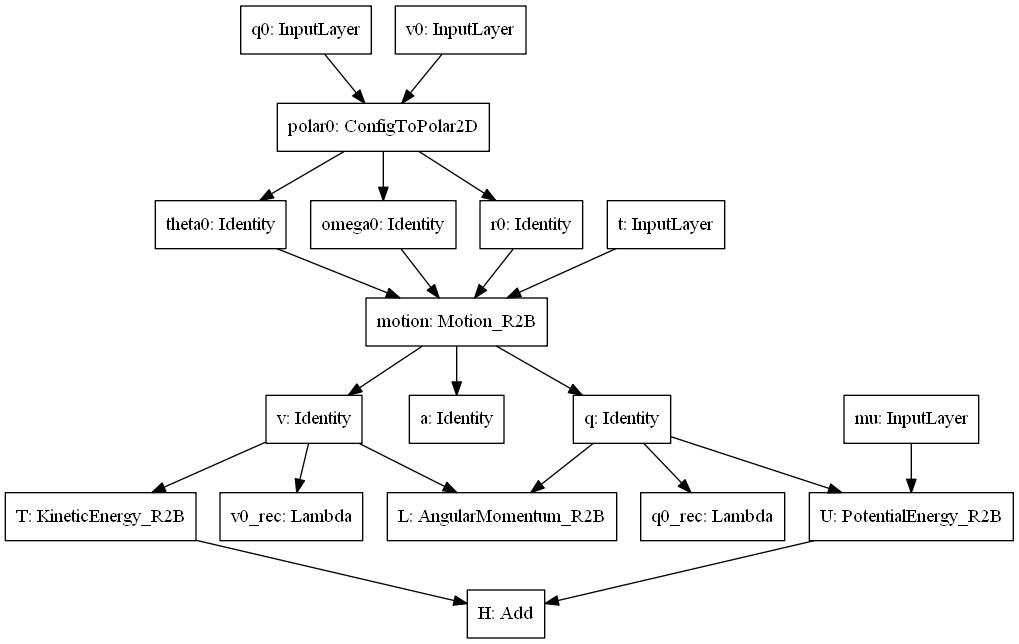

In [29]:
keras.utils.plot_model(model_math)

In [30]:
# model_math.summary()

In [31]:
q, v, a, q0_rec, v0_rec, H, L  = model_math([t, q0, v0, mu])
print(f'model output shapes:')
print(f'q = {q.shape}')
print(f'v = {v.shape}')
print(f'a = {a.shape}')
print(f'q0_rec = {q0_rec.shape}')
print(f'v0_rec = {v0_rec.shape}')
print(f'H = {H.shape}')
print(f'L = {L.shape}')

model output shapes:
q = (64, 731, 2)
v = (64, 731, 2)
a = (64, 731, 2)
q0_rec = (64, 2)
v0_rec = (64, 2)
H = (64, 731)
L = (64, 731)


In [32]:
optimizer = keras.optimizers.Adam()

loss = {'q': keras.losses.MeanSquaredError(name='q_mse'),
        'v': keras.losses.MeanSquaredError(name='q_mse'),
        'a': keras.losses.MeanSquaredError(name='a_mse'),
        'q0_rec': keras.losses.MeanSquaredError(name='q0_mse'),
        'v0_rec': keras.losses.MeanSquaredError(name='v0_mse'),
        'H': keras.losses.MeanSquaredError(name='H'),
        'L': keras.losses.MeanSquaredError(name='L')}

# these metrics produce crazy output names when multiple instances share them; hold off for now
# metrics = {'q': keras.metrics.MeanAbsoluteError(name='q_mae'),
#            'v': keras.metrics.MeanAbsoluteError(name='v_mae')}
metrics = None

loss_weights = {'q': 1.0,
                'v': 1.0,
                'a': 0.0,
                'q0_rec': 1.0,
                'v0_rec': 1.0,
                'H': 1.0,
                'L': 1.0}

In [33]:
# Compile the mathematical model on a single GPU
# model_math = make_model_r2bc_math()
model_math.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

In [34]:
# Compile the mathematical model for parallel GPUs
# with strat.scope():
#     model_math_par = make_model_r2bc_analytic()
#     model_math_par.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

In [35]:
# Evaluate the math model on the earth-like data set
model_math.evaluate(ds_solar_val)

32/32 [==============================] - 1s 37ms/step - loss: 1.0400e-11 - q_loss: 1.0601e-12 - v_loss: 9.3822e-13 - a_loss: 1.8915e-10 - q0_rec_loss: 6.7927e-13 - v0_rec_loss: 1.6890e-14 - H_loss: 8.9976e-13 - L_loss: 6.8054e-12


[1.0399643589321071e-11,
 1.0601153e-12,
 9.382155e-13,
 1.8915154e-10,
 6.79265e-13,
 1.6890155e-14,
 8.9975656e-13,
 6.8054013e-12]

In [36]:
def time_model_eval(model, ds, batches=None, time_mean=None):
    """Time a model to evaluate a dataset"""
    t0 = time.time()
    if batches is None:
        model.evaluate(ds)
    else:
        model.evaluate(ds.take(batches))
    t1 = time.time()
    elapsed = t1 - t0
    print(f'Elapsed Time: {elapsed:5.3f} sec')
    if time_mean is not None:
        delta = (elapsed - time_mean)
        print(f'Time Delta:   {delta:+5.3f} sec')

In [37]:
# Time the single GPU math model
# time_model_eval(model_math, ds_solar_trn)

In [38]:
# Time the double GPU math model
# time_model_eval(model_math_par, ds_solar_trn)

In [273]:
def make_position_model_r2bc_nn(hidden_sizes, skip_layers=True, traj_size = 731):
    """
    Compute orbit positions for the restricted two body circular problem from 
    the initial polar coordinates (orbital elements) with a deterministic mathematical model.
    Factory function that returns a functional model.
    """
    # Create input layers
    t = keras.Input(shape=(traj_size,), name='t')
    q0 = keras.Input(shape=(2,), name='q0')
    v0 = keras.Input(shape=(2,), name='v0')
    mu = keras.Input(shape=(1,), name='mu')
    # The combined input layers
    inputs = [t, q0, v0, mu]

    # Check sizes
    batch_size = t.shape[0]
    tf.debugging.assert_shapes(shapes={
        t: (batch_size, traj_size),
        q0: (batch_size, 2),
        v0: (batch_size, 2),
        mu: (batch_size, 1),
    }, message='make_position_model_r2bc_nn / inputs')
    
    # The polar coordinates of the initial conditions
    # r0, theta0, and omega0 each scalars in each batch
    r0, theta0, omega0 = ConfigToPolar2D(name='polar0')([q0, v0])
    
    # Name the outputs of the initial polar
    # These each have shape (batch_size, 1)
    r0 = Identity(name='r0')(r0)
    theta0 = Identity(name='theta0')(theta0)
    omega0 = Identity(name='omega0')(omega0)

    # Check sizes
    tf.debugging.assert_shapes(shapes={
        r0: (batch_size, 1),
        theta0: (batch_size, 1),
        omega0: (batch_size, 1),
    }, message='make_position_model_r2bc_nn / polar elements r0, theta0, omega0')
   
    # Combine the trajectory-wide scalars into one feature
    # Size of each row is 2+2+1+1+1=7; shape is (batch_size, 7)
    phi_traj = keras.layers.concatenate(inputs=[q0, v0, r0, theta0, omega0], name='phi_traj')
    
    # Repeat phi_traj traj_size times so it has a shape of (batch_size, traj_size, 7)
    phi_traj_vec = keras.layers.RepeatVector(n=traj_size, name='phi_traj_vec')(phi_traj)

    # Reshape t to (batch_size, traj_size, 1)
    t_vec = keras.layers.Reshape(target_shape=(traj_size, 1), name='t_vec')(t)
    
    # Concatenate phi_traj with the time t to make the initial feature vector phi_0
    phi_0 = keras.layers.concatenate(inputs=[t_vec, phi_traj_vec], name='phi_0')
    
    # Hidden layers as specified in hidden_sizes
    # Number of hidden layers
    num_layers = len(hidden_sizes)

    # phi_n will update to the last available feature layer for the output portion
    phi_n = phi_0

    # First hidden layer if applicable
    if num_layers > 0:
        phi_1 = keras.layers.Dense(units=hidden_sizes[0], activation='tanh', name='phi_1')(phi_0)
        if skip_layers:
            phi_1 = keras.layers.concatenate(inputs=[phi_0, phi_1], name='phi_1_aug')
        phi_n = phi_1

    # Second hidden layer if applicable
    if num_layers > 1:
        phi_2 = keras.layers.Dense(units=hidden_sizes[1], activation='tanh', name='phi_2')(phi_1)
        if skip_layers:
            phi_2 = keras.layers.concatenate(inputs=[phi_1, phi_2], name='phi_2_aug')
        phi_n = phi_2
    
    # Check shapes
    tf.debugging.assert_shapes(shapes={
        phi_traj: (batch_size, 7),
        phi_traj_vec: (batch_size, traj_size, 7),        
        t_vec: (batch_size, traj_size, 1),
        phi_0: (batch_size, traj_size, 8),
        # phi_1: (batch_size, traj_size, 'hs1'),
        # phi_2: (batch_size, traj_size, 'hs2'),
    }, message='make_position_model_r2bc_nn / phi')

    # Compute the radius r from the features; initialize weights to 0, bias to 1
    r = keras.layers.Dense(
        units=1, kernel_initializer='zeros', bias_initializer='ones', name='r')(phi_n)
    
    # Compute the mean angular frequency omega from the features
    omega = keras.layers.Dense(
        units=1, kernel_initializer='zeros', bias_initializer='zeros', name='omega') (phi_n)
    
    # Add a feature for omega * t + theta0; a rough estimate of the angular offset
    omega_t = keras.layers.multiply(inputs=[omega, t_vec], name='omega_t')

    # Compute the offset to angle theta to its mean trend from the features
    theta_adj = keras.layers.Dense(
        units=1, kernel_initializer='zeros', bias_initializer='zeros', name='theta_adj')(phi_n)
    
    # Compute the angle theta as the sum of its original offset theta0, its trend rate omega_bar_t
    # and the adjustment above
    theta0_vec = keras.layers.RepeatVector(n=traj_size, name='theta0_vec')(theta0)
    theta = keras.layers.add(inputs=[omega_t, theta0_vec, theta_adj], name='theta')
    
    # Check shapes
    tf.debugging.assert_shapes(shapes={
        r: (batch_size, traj_size, 1),
        omega: (batch_size, traj_size, 1),
        omega_t: (batch_size, traj_size, 1),
        theta_adj: (batch_size, traj_size, 1),
        theta0_vec: (batch_size, traj_size, 1),
        theta: (batch_size, traj_size, 1)
    }, message='make_position_model_r2bc_nn / r, omega, theta')
    
    # Cosine and sine of theta
    cos_theta = keras.layers.Activation(activation=tf.cos, name='cos_theta')(theta)
    sin_theta = keras.layers.Activation(activation=tf.sin, name='sin_theta')(theta)

    # Compute qx and qy from r, theta
    qx = keras.layers.multiply(inputs=[r, cos_theta], name='qx')
    qy = keras.layers.multiply(inputs=[r, sin_theta], name='qy')
    
    # Check shapes
    batch_size = t.shape[0]
    tf.debugging.assert_shapes(shapes={
        cos_theta: (batch_size, traj_size, 1),
        sin_theta: (batch_size, traj_size, 1),
        qx: (batch_size, traj_size, 1),
        qy: (batch_size, traj_size, 1),
    }, message='make_position_model_r2bc_nn / outputs')
    
    # Wrap this into a model
    outputs = [qx, qy]
    model = keras.Model(inputs=inputs, outputs=outputs, name='model_r2bc_nn')
    return model

In [274]:
def make_model_r2bc_nn(hidden_sizes, skip_layers=True, traj_size: int = 731):
    """Create a neural net model for the restricted two body circular problem"""
    # Build the position model
    position_model = make_position_model_r2bc_nn(hidden_sizes=hidden_sizes, skip_layers=skip_layers)
    
    # Build the model with this position model and the input trajectory size
    return make_physics_model_r2bc_nn(position_model=position_model, traj_size=traj_size)

In [275]:
position_model_nn = make_position_model_r2bc_nn([64])

In [276]:
position_model_nn.summary()

Model: "model_r2bc_nn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
q0 (InputLayer)                 [(None, 2)]          0                                            
__________________________________________________________________________________________________
v0 (InputLayer)                 [(None, 2)]          0                                            
__________________________________________________________________________________________________
polar0 (ConfigToPolar2D)        ((None, 1), (None, 1 0           q0[0][0]                         
                                                                 v0[0][0]                         
__________________________________________________________________________________________________
r0 (Identity)                   (None, 1)            0           polar0[0][0]         

In [277]:
qx, qy = position_model_nn([t, q0, v0, mu])
print(f'qx = {qx.shape}')
print(f'qy = {qy.shape}')

qx = (64, 731, 1)
qy = (64, 731, 1)


In [278]:
motion_model_nn = Motion_R2B(position_model=position_model_nn, name='motion_model_nn')

In [279]:
q, v, a = motion_model_nn([t, q0, v0, mu])
print('shape of motion_model outputs:')
print(f'q: {q.shape}')
print(f'v: {v.shape}')
print(f'a: {a.shape}')

shape of motion_model outputs:
q: (64, 731, 2)
v: (64, 731, 2)
a: (64, 731, 2)


In [280]:
optimizer = keras.optimizers.Adam(learning_rate=1.0E-3)

loss_weights = {'q': 1.0,
                'v': 1.0,
                'a': 1.0,
                'q0_rec': 1.0,
                'v0_rec': 1.0,
                'H': 0.1,
                'L': 0.1}

In [286]:
# Make the NN r2bc model
model_nn = make_model_r2bc_nn(hidden_sizes=[64, 16], skip_layers=True, traj_size=traj_size)
model_nn.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights)

In [287]:
# Evaluate the NN model on the solar system data set
model_nn.evaluate(ds_solar_val)

32/32 [==============================] - 4s 113ms/step - loss: 622.6295 - q_loss: 167.4748 - v_loss: 2.5419 - a_loss: 78.0774 - q0_rec_loss: 167.1246 - v0_rec_loss: 2.5419 - H_loss: 1383.3395 - L_loss: 665.3488


[622.6295461654663,
 167.4748,
 2.541923,
 78.07742,
 167.12463,
 2.541923,
 1383.3395,
 665.34875]

In [288]:
hist = model_nn.fit(ds_solar_trn, epochs=20)

Epoch 1/20
157/157 [==============================] - 17s 108ms/step - loss: 141.0985 - q_loss: 32.8869 - v_loss: 1.6233 - a_loss: 61.5840 - q0_rec_loss: 31.7998 - v0_rec_loss: 1.1376 - H_loss: 30.6655 - L_loss: 89.9636
Epoch 2/20
157/157 [==============================] - 6s 37ms/step - loss: 70.7476 - q_loss: 3.5415 - v_loss: 1.1911 - a_loss: 61.0285 - q0_rec_loss: 3.4593 - v0_rec_loss: 0.6996 - H_loss: 2.0939 - L_loss: 6.1620
Epoch 3/20
157/157 [==============================] - 6s 37ms/step - loss: 70.5077 - q_loss: 1.7239 - v_loss: 1.2145 - a_loss: 60.9749 - q0_rec_loss: 1.4400 - v0_rec_loss: 0.6517 - H_loss: 7.1305 - L_loss: 37.8762
Epoch 4/20
157/157 [==============================] - 6s 38ms/step - loss: 66.1859 - q_loss: 1.0279 - v_loss: 1.0798 - a_loss: 60.4840 - q0_rec_loss: 0.8155 - v0_rec_loss: 0.5381 - H_loss: 2.3811 - L_loss: 20.0070
Epoch 5/20
157/157 [==============================] - 6s 37ms/step - loss: 62.0569 - q_loss: 0.5864 - v_loss: 0.9466 - a_loss: 58.7957 - q0

In [211]:
def compile_and_fit(model, ds, epochs, loss, optimizer, metrics, save_freq):
    # Compile the model
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    model_name = model.name
    filepath=f'../models/r2bc/{model_name}.h5'

    # Create callbacks
    interval = max(epochs // 20, 1)
    patience = max(epochs // 10, 1)
    cb_log = EpochLoss(interval=interval)
    cb_time = TimeHistory()

#     cb_ckp = keras.callbacks.ModelCheckpoint(
#             filepath=filepath, 
#             save_freq=save_freq,
#             save_best_only=True,
#             save_weights_only=True,
#             monitor='loss',
#             verbose=0)    

    cb_early_stop = keras.callbacks.EarlyStopping(
            monitor='loss',
            min_delta=1.0E-8,
            patience=patience,
            verbose=1,
            restore_best_weights=True)    
    # callbacks = [cb_log, cb_time, cb_ckp, cb_early_stop]
    callbacks = [cb_log, cb_time, cb_early_stop]
    
    # Fit the model
    hist = model.fit(ds, epochs=epochs, callbacks=callbacks, verbose=0)
    # Add the times to the history
    hist.history['time'] = cb_time.times
    
    # Restore the model to the best weights
    # model.load_weights(filepath)

    return hist

In [213]:
epochs = 1
epoch_size = 10000
samples_total = epochs * epoch_size

# Set save_freq in terms of SAMPLES
save_freq = samples_total // 10

In [219]:
# hist = compile_and_fit(model=model_nn, 
#                        ds=ds_solar_trn, 
#                        epochs=epochs,
#                        loss=loss, 
#                        optimizer=optimizer,
#                        metrics=metrics,
#                        save_freq=save_freq)

Epoch 0001; loss 9.85e+08; elapsed 0:00:16


In [156]:
model_nn.weights

ListWrapper([<tf.Variable 'r_23/kernel:0' shape=(8, 1) dtype=float32, numpy=
array([[-0.09185164],
       [-0.00174467],
       [ 0.0019609 ],
       [-0.00209787],
       [ 0.00126752],
       [ 0.9771945 ],
       [-0.0047297 ],
       [-0.01798369]], dtype=float32)>, <tf.Variable 'r_23/bias:0' shape=(1,) dtype=float32, numpy=array([0.3576834], dtype=float32)>])